# Nearest neighbors crossmatch

Two new features were implemented for the K Nearest Neighbors crossmatch routine. 

The first one allows to crossmatch with a radius range. As such, apart from the existing `radius_arcsec` argument that we used to specify a maximum radius we now also have a `min_radius_arcsec` that indicates the minimum separation distance for the crossmatch. 

The second allows to keep **non-matches** for all the objects in the left catalog. Before the only possibility was to keep the matches.

To make this possible two new arguments were introduced:

```python
catalog_a.crossmatch(
    catalog_b, 
    n_neighbors=1, 
    radius_arcsec=1.2*3600, 
    # new arguments
    min_radius_arcsec=0.5*3600,
    keep_non_matches=True,
)
```

In [1]:
import lsdb

In [2]:
import os

data_dir = "kdtree-crossmatch"

small_sky_dir = os.path.join(data_dir, "small_sky")
small_sky = lsdb.read_hipscat(small_sky_dir)

# Create a copy of small_sky for self-matching, otherwise we will have duplicate column metadata
small_sky_2 = lsdb.read_hipscat(small_sky_dir)
small_sky_2.hc_structure.catalog_name = "small_sky_2"

## Helpers methods

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_crossmatch(catalog_1, catalog_2, xmatch, radius_inner=None, radius_outer=None, window=None):
    xmatch_df = xmatch.compute()
    
    cat_2_name = catalog_2.hc_structure.catalog_name    
    ra_xmatch = wrap_ra_range(xmatch_df[f"ra_{cat_2_name}"])
    dec_xmatch = xmatch_df[f"dec_{cat_2_name}"]
    
    plot_points(catalog_1, catalog_2, ra_xmatch, dec_xmatch)
    plot_radius(ra_xmatch, dec_xmatch, radius_inner, radius_outer)
    
    if window:
        plt.axis(window)
    plt.gca().set_aspect('equal')
    
    plt.xlabel("RA")
    plt.ylabel("Dec")
    plt.legend()
    
def plot_points(catalog_1, catalog_2, ra_xmatch, dec_xmatch):
    cat_1_df = catalog_1.compute()
    cat_2_df = catalog_2.compute()
    
    cat_1_name = catalog_1.hc_structure.catalog_name
    cat_2_name = catalog_2.hc_structure.catalog_name
    
    ra_cat_1 = wrap_ra_range(cat_1_df["ra"])
    ra_cat_2 = wrap_ra_range(cat_2_df["ra"])
    
    plt.scatter(ra_cat_1, cat_1_df["dec"], s=50, alpha=1, color="green", label=cat_1_name)
    plt.scatter(ra_cat_2, cat_2_df["dec"], s=10, alpha=1,color="red", label=cat_2_name)  
    plt.scatter(ra_xmatch, dec_xmatch, s=10, alpha=1, marker="+", color="blue", label="x-match")
    
def plot_radius(ra_xmatch, dec_xmatch, radius_inner, radius_outer):
    for ra, dec in zip(ra_xmatch, dec_xmatch):
        if radius_inner:
            circle = plt.Circle((ra,dec), radius=radius_inner, edgecolor='yellow', facecolor='none')
            plt.gca().add_patch(circle)
        if radius_outer:
            circle = plt.Circle((ra,dec), radius=radius_outer, edgecolor='orange', facecolor='none')
            plt.gca().add_patch(circle)

def wrap_ra_range(ra):
    return np.where(ra > 180, ra - 360, ra)

## Minimum radius threshold

Having a minimum radius threshold is useful, for example, when performing a self-crossmatch, i.e. matching a catalog against itself. With the previous implementation, the nearest neighbor for an object would always correspond to itself as they overlap and their separation is 0.

In [4]:
xmatched = small_sky.crossmatch(
    small_sky_2, 
    n_neighbors=1, 
    radius_arcsec=1*3600,
    require_right_margin=False,
)
xmatched_df = xmatched.compute()
xmatched_df[["id_small_sky", "id_small_sky_2", "_dist_arcsec"]].head(n=10)

/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


,id_small_sky,id_small_sky_2,_dist_arcsec
_hipscat_index,,,
12749688880727326720,707,707,0.0
12751184493818150912,792,792,0.0
12753202806647685120,723,723,0.0
12753202806647685121,811,723,0.0
12770681119980912640,826,826,0.0
12771980657148559360,750,750,0.0
12776409575968473088,771,771,0.0
12782714789977653248,734,734,0.0
12786706826733289472,738,738,0.0


In [5]:
assert all(xmatched_df["_dist_arcsec"] == 0)

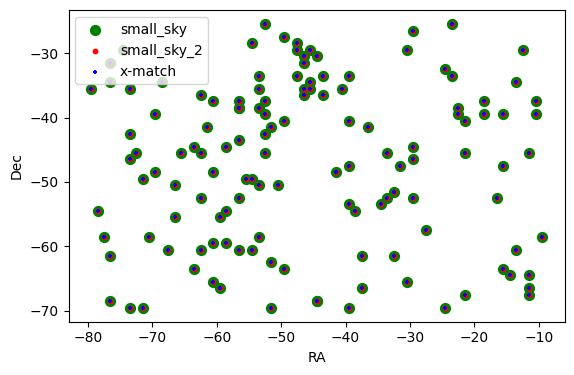

In [6]:
plot_crossmatch(small_sky, small_sky_2, xmatched)

Performing the crossmatch with a minimum distance of 1 arcsecond the objects do not overlap anymore. We also get fewer number of matches because the points won't consider themselves as neighbors. We skip these self-matches, effectively getting the real nearest object for each of them.

In [7]:
# Create a copy of small_sky, otherwise we will have duplicate column metadata when crossmatching
xmatched = small_sky.crossmatch(
    small_sky_2,
    n_neighbors=1,
    min_radius_arcsec=1,
    radius_arcsec=1.2*3600,
    require_right_margin=False,
)
xmatched_df = xmatched.compute()
xmatched_df[["id_small_sky", "id_small_sky_2", "_dist_arcsec"]].head(n=10)

/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


,id_small_sky,id_small_sky_2,_dist_arcsec
_hipscat_index,,,
12776409575968473088,771,734,3600.000000
12782714789977653248,734,771,3600.000000
12786706826733289472,738,776,3930.598179
12788339839317573632,776,738,3930.598179
12842381331509805056,816,703,2521.380830
12842473731565551616,703,816,2521.380830
12855054043935932416,794,735,3886.272010
12856781556059996160,735,794,3886.272010
12886291525662670848,716,807,3545.313276


In [8]:
assert all(xmatched_df["_dist_arcsec"] != 0)

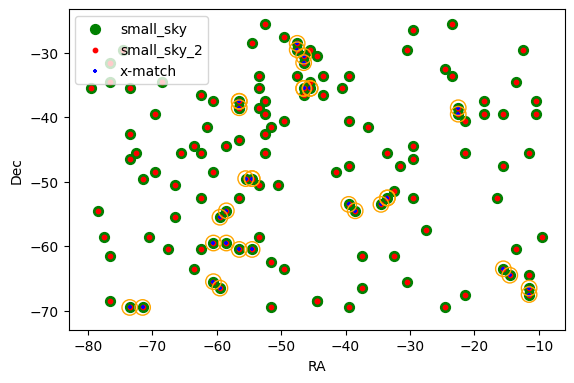

In [9]:
plot_crossmatch(small_sky, small_sky_2, xmatched, radius_outer=1.2)

We can also request multiple neighbors, as before, but now within a radius range:

In [10]:
xmatched = small_sky.crossmatch(
    small_sky_2,
    n_neighbors=3,
    min_radius_arcsec=0.5*3600,
    radius_arcsec=1.2*3600,
    require_right_margin=False,
)
xmatched_df = xmatched.compute()
xmatched_df[["id_small_sky", "id_small_sky_2", "_dist_arcsec"]].head(n=10)

/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


,id_small_sky,id_small_sky_2,_dist_arcsec
_hipscat_index,,,
12776409575968473088,771,734,3600.000000
12782714789977653248,734,771,3600.000000
12786706826733289472,738,776,3930.598179
12788339839317573632,776,738,3930.598179
12842381331509805056,816,703,2521.380830
12842473731565551616,703,816,2521.380830
12855054043935932416,794,735,3886.272010
12856781556059996160,735,794,3886.272010
12886291525662670848,716,807,3545.313276


In [11]:
assert all(xmatched_df["_dist_arcsec"] != 0)
print(f"Min separation (deg): {min(xmatched_df['_dist_arcsec'] / 3600)}")
print(f"Max separation (deg): {max(xmatched_df['_dist_arcsec']) / 3600}")

Min separation (deg): 0.6494432820061775
Max separation (deg): 1.1887449591239863


In [12]:
xmatched_df.groupby("id_small_sky").size()

id_small_sky
703    1
711    2
714    2
716    1
721    1
729    1
732    1
734    1
735    1
738    1
741    1
745    1
754    1
755    1
758    1
760    1
762    1
771    1
775    1
776    1
778    1
780    2
791    1
794    1
799    1
802    1
806    1
807    1
810    1
816    1
818    1
819    2
822    1
829    2
830    1
dtype: int64

Let's zoom into one of the object with two neighbor matches (object **ID 711** around (-55 RA, -50 DEC)):

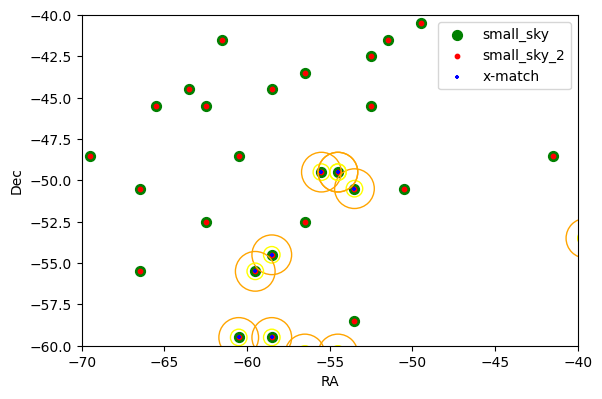

In [13]:
plot_crossmatch(small_sky, small_sky_2, xmatched, radius_inner=0.5, radius_outer=1.2, window=[-70,-40,-60,-40])

## Non-matches

We can now also decide to keep the "non-matches", i.e., all the objects in the left catalog that do not have a match in the right catalog. Until now the output of the nearest neighbors crossmatch performed a "inner" join operation, dropping all the objects without a match.

In [14]:
xmatched = small_sky.crossmatch(
    small_sky_2,
    n_neighbors=1,
    min_radius_arcsec=0.5*3600,
    radius_arcsec=1.2*3600,
    require_right_margin=False,
    keep_non_matches=True,
)
xmatched_df = xmatched.compute()
xmatched_df

/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)
/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/core/crossmatch/kdtree_match.py:83: RuntimeWarning: invalid value encountered in arcsin
  arc_distances = np.degrees(2.0 * np.arcsin(0.5 * chord_distances)) * 3600


,id_small_sky,ra_small_sky,dec_small_sky,ra_error_small_sky,dec_error_small_sky,Norder_small_sky,Dir_small_sky,Npix_small_sky,id_small_sky_2,ra_small_sky_2,dec_small_sky_2,ra_error_small_sky_2,dec_error_small_sky_2,Norder_small_sky_2,Dir_small_sky_2,Npix_small_sky_2,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,
12749688880727326720,707,308.5,-69.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12751184493818150912,792,320.5,-69.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12753202806647685120,723,315.5,-68.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12753202806647685121,811,315.5,-68.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12770681119980912640,826,335.5,-69.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13591216801265483776,791,312.5,-28.5,0,0,0,0,11,806.0,312.5,-29.5,0.0,0.0,0.0,0.0,11.0,3600.0
13596001812279721984,824,305.5,-28.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13598131468743213056,702,310.5,-27.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# If we include non-matches, for k=1, the resulting dataframe is the size of the original catalog
assert len(xmatched_df) == len(small_sky.compute())

The non-matches have NaN crossmatch information (namely ID, `id_small_sky_2`, and distance, `_dist_arcsec`). If we have the result with non-matches and we want to then obtain the set of matches we can simply filter the data by valid distance, as demonstrated below:

In [16]:
xmatched_df[~xmatched_df["_dist_arcsec"].isna()].head(n=10)

,id_small_sky,ra_small_sky,dec_small_sky,ra_error_small_sky,dec_error_small_sky,Norder_small_sky,Dir_small_sky,Npix_small_sky,id_small_sky_2,ra_small_sky_2,dec_small_sky_2,ra_error_small_sky_2,dec_error_small_sky_2,Norder_small_sky_2,Dir_small_sky_2,Npix_small_sky_2,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,
12776409575968473088,771,348.5,-67.5,0,0,0,0,11,734.0,348.5,-66.5,0.0,0.0,0.0,0.0,11.0,3600.000000
12782714789977653248,734,348.5,-66.5,0,0,0,0,11,771.0,348.5,-67.5,0.0,0.0,0.0,0.0,11.0,3600.000000
12786706826733289472,738,345.5,-64.5,0,0,0,0,11,776.0,344.5,-63.5,0.0,0.0,0.0,0.0,11.0,3930.598179
12788339839317573632,776,344.5,-63.5,0,0,0,0,11,738.0,345.5,-64.5,0.0,0.0,0.0,0.0,11.0,3930.598179
12842381331509805056,816,288.5,-69.5,0,0,0,0,11,703.0,286.5,-69.5,0.0,0.0,0.0,0.0,11.0,2521.380830
12842473731565551616,703,286.5,-69.5,0,0,0,0,11,816.0,288.5,-69.5,0.0,0.0,0.0,0.0,11.0,2521.380830
12855054043935932416,794,300.5,-66.5,0,0,0,0,11,735.0,299.5,-65.5,0.0,0.0,0.0,0.0,11.0,3886.272010
12856781556059996160,735,299.5,-65.5,0,0,0,0,11,794.0,300.5,-66.5,0.0,0.0,0.0,0.0,11.0,3886.272010
12886291525662670848,716,305.5,-60.5,0,0,0,0,11,807.0,303.5,-60.5,0.0,0.0,0.0,0.0,11.0,3545.313276


Requesting a higher number of neighbors may yield a higher number of rows because we can have several neighbors for each object in the left partition.

In [17]:
xmatched = small_sky.crossmatch(
    small_sky_2,
    n_neighbors=4,
    min_radius_arcsec=0.02*3600,
    radius_arcsec=1.5*3600,
    require_right_margin=False,
    keep_non_matches=True,
)
xmatched_df = xmatched.compute()
xmatched_df

/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)
/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/core/crossmatch/kdtree_match.py:83: RuntimeWarning: invalid value encountered in arcsin
  arc_distances = np.degrees(2.0 * np.arcsin(0.5 * chord_distances)) * 3600


,id_small_sky,ra_small_sky,dec_small_sky,ra_error_small_sky,dec_error_small_sky,Norder_small_sky,Dir_small_sky,Npix_small_sky,id_small_sky_2,ra_small_sky_2,dec_small_sky_2,ra_error_small_sky_2,dec_error_small_sky_2,Norder_small_sky_2,Dir_small_sky_2,Npix_small_sky_2,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,
12749688880727326720,707,308.5,-69.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12751184493818150912,792,320.5,-69.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12753202806647685120,723,315.5,-68.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12753202806647685121,811,315.5,-68.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12770681119980912640,826,335.5,-69.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13596001812279721984,824,305.5,-28.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13598131468743213056,702,310.5,-27.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13601023174257934336,767,314.5,-29.5,0,0,0,0,11,825.0,315.5,-30.5,0.0,0.0,0.0,0.0,11.0,4762.294072


Here we have the set of objects that, for the distance range provided, have more than 1 neighbors:

In [18]:
sizes = xmatched_df.groupby("id_small_sky").size()
sizes[sizes > 1]

id_small_sky
703    2
711    2
714    2
721    2
729    2
732    2
738    2
754    3
763    2
767    2
778    2
780    2
806    2
807    2
810    2
819    3
829    3
dtype: int64

There are 77 objects without matches:

In [19]:
non_matches_df = xmatched_df[xmatched_df["_dist_arcsec"].isna()]
non_matches_df[["id_small_sky", "id_small_sky_2"]]

,id_small_sky,id_small_sky_2
_hipscat_index,,
12749688880727326720,707,NaN
12751184493818150912,792,NaN
12753202806647685120,723,NaN
12753202806647685121,811,NaN
12770681119980912640,826,NaN
...,...,...
13561582046530240512,737,NaN
13565852277582856192,796,NaN
13596001812279721984,824,NaN


An object will appear in the resulting catalog as many times as there are matches for it (one row per match). If an object has no matches, there is only one row/occurrence of that object in the resulting catalog.

In [20]:
duplicated_mask = xmatched_df["id_small_sky"].duplicated()
duplicates = np.unique(xmatched_df[duplicated_mask]["id_small_sky"])
assert np.array_equal(duplicates, sizes[sizes > 1].index.values)

assert not non_matches_df["id_small_sky"].duplicated().any()

## Crossmatching different catalogs

In [21]:
small_sky_xmatch_margin_dir = os.path.join(data_dir, "small_sky_xmatch_margin")
small_sky_small_sky_xmatch_margin = lsdb.read_hipscat(small_sky_xmatch_margin_dir)

small_sky_xmatch_dir = os.path.join(data_dir, "small_sky_xmatch")
small_sky_xmatch = lsdb.read_hipscat(small_sky_xmatch_dir, margin_cache=small_sky_small_sky_xmatch_margin)

In [22]:
xmatched = small_sky.crossmatch(
    small_sky_xmatch,
    n_neighbors=3,
    min_radius_arcsec=0.5*3600,
    radius_arcsec=1.2*3600,
    keep_non_matches=True,
    require_right_margin=False
)
xmatched_df = xmatched.compute()
xmatched_df

/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/core/crossmatch/kdtree_match.py:83: RuntimeWarning: invalid value encountered in arcsin
  arc_distances = np.degrees(2.0 * np.arcsin(0.5 * chord_distances)) * 3600
/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/core/crossmatch/kdtree_match.py:83: RuntimeWarning: invalid value encountered in arcsin
  arc_distances = np.degrees(2.0 * np.arcsin(0.5 * chord_distances)) * 3600
/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/core/crossmatch/kdtree_match.py:83: RuntimeWarning: invalid value encountered in arcsin
  arc_distances = np.degrees(2.0 * np.arcsin(0.5 * chord_distances)) * 3600
/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/core/crossmatch/kdtree_match.py:83: RuntimeWarning: invalid value encountered in arcsin
  arc_distances = np.degrees(2.0 * np.arcsin(0.5 * chord_distances)) * 3600


,id_small_sky,ra_small_sky,dec_small_sky,ra_error_small_sky,dec_error_small_sky,Norder_small_sky,Dir_small_sky,Npix_small_sky,id_small_sky_xmatch,ra_small_sky_xmatch,dec_small_sky_xmatch,ra_error_small_sky_xmatch,dec_error_small_sky_xmatch,calculated_dist_small_sky_xmatch,Norder_small_sky_xmatch,Dir_small_sky_xmatch,Npix_small_sky_xmatch,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,,
12749688880727326720,707,308.5,-69.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12751184493818150912,792,320.5,-69.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12753202806647685120,723,315.5,-68.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12753202806647685121,811,315.5,-68.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12770681119980912640,826,335.5,-69.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13591216801265483776,791,312.5,-28.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13596001812279721984,824,305.5,-28.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13598131468743213056,702,310.5,-27.5,0,0,0,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/core/crossmatch/kdtree_match.py:83: RuntimeWarning: invalid value encountered in arcsin
  arc_distances = np.degrees(2.0 * np.arcsin(0.5 * chord_distances)) * 3600
/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/core/crossmatch/kdtree_match.py:83: RuntimeWarning: invalid value encountered in arcsin
  arc_distances = np.degrees(2.0 * np.arcsin(0.5 * chord_distances)) * 3600
/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/core/crossmatch/kdtree_match.py:83: RuntimeWarning: invalid value encountered in arcsin
  arc_distances = np.degrees(2.0 * np.arcsin(0.5 * chord_distances)) * 3600


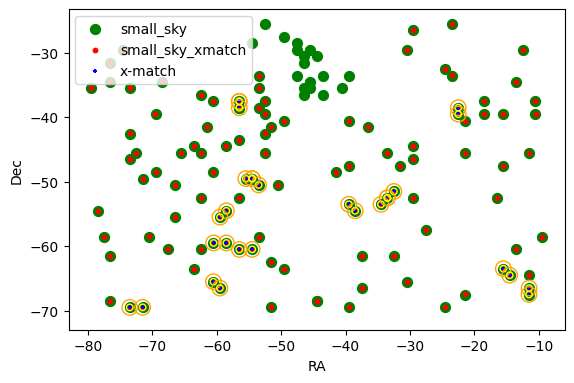

In [23]:
plot_crossmatch(small_sky, small_sky_xmatch, xmatched, radius_inner=0.5, radius_outer=1.2)

In [24]:
catalogs_dir = "/epyc/data3/hipscat/catalogs"
ztf_dr14 = lsdb.read_hipscat(f"{catalogs_dir}/ztf_axs/ztf_dr14", columns=["ps1_objid", "ra", "dec"])
gaia_dr3 = lsdb.read_hipscat(f"{catalogs_dir}/gaia_dr3/gaia", columns=["source_id", "ra", "dec"])

In [25]:
from dask.distributed import Client

ra_range = (60,61)
dec_range = (20,21)

with Client(n_workers=8) as client:
    ztf_dr14 = ztf_dr14.box(ra=ra_range, dec=dec_range)
    gaia_dr3 = gaia_dr3.box(ra=ra_range, dec=dec_range)

/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46348 instead
  warnings.warn(


In [26]:
xmatched = ztf_dr14.crossmatch(
    gaia_dr3,
    n_neighbors=2,
    radius_arcsec=5,
    keep_non_matches=True,
    require_right_margin=False
)
xmatched_df = xmatched.compute()
xmatched_df

/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)
/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/core/crossmatch/kdtree_match.py:83: RuntimeWarning: invalid value encountered in arcsin
  arc_distances = np.degrees(2.0 * np.arcsin(0.5 * chord_distances)) * 3600


,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,source_id_gaia,ra_gaia,dec_gaia,_dist_arcsec
_hipscat_index,,,,,,,
101110539291197440,132000605789626727,60.578758,20.005308,NaN,NaN,NaN,NaN
101110891361075200,132000605688793714,60.569088,20.002586,NaN,NaN,NaN,NaN
101110896931110912,132000605675954253,60.567732,20.003158,NaN,NaN,NaN,NaN
101110941373956096,132010605689704006,60.568919,20.011092,NaN,NaN,NaN,NaN
101111012031201280,132010605428941413,60.542915,20.009085,5.055548e+16,60.542922,20.009074,0.046314
...,...,...,...,...,...,...,...
105878647914627072,133190602173807801,60.217407,20.997812,5.293932e+16,60.217402,20.997789,0.085901
105878650594787328,133190602151886930,60.215206,20.997173,NaN,NaN,NaN,NaN
105878650594787329,133190602155587103,60.215206,20.997173,NaN,NaN,NaN,NaN


In [27]:
xmatched_df[~xmatched_df["_dist_arcsec"].isna()]

,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,source_id_gaia,ra_gaia,dec_gaia,_dist_arcsec
_hipscat_index,,,,,,,
101111012031201280,132010605428941413,60.542915,20.009085,5.055548e+16,60.542922,20.009074,0.046314
101115285435580416,132000603919511739,60.391996,20.001004,5.055764e+16,60.391993,20.000990,0.050899
101115305723428864,132000603990448859,60.399082,20.006924,5.055764e+16,60.399078,20.006929,0.023302
101115379526402048,132000603721009409,60.372116,20.007390,5.055767e+16,60.372123,20.007386,0.025532
101115392298057728,132010603678970067,60.367923,20.007953,5.055767e+16,60.367932,20.007935,0.071014
...,...,...,...,...,...,...,...
105873223425458176,133190602793107149,60.279345,20.997192,5.293661e+16,60.279338,20.997180,0.049911
105874244285497344,133190603932964143,60.393293,20.994686,5.293713e+16,60.393312,20.994662,0.106855
105878598266650624,133180602071409708,60.207190,20.991017,5.293929e+16,60.207176,20.990981,0.137561


/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/core/crossmatch/kdtree_match.py:83: RuntimeWarning: invalid value encountered in arcsin
  arc_distances = np.degrees(2.0 * np.arcsin(0.5 * chord_distances)) * 3600


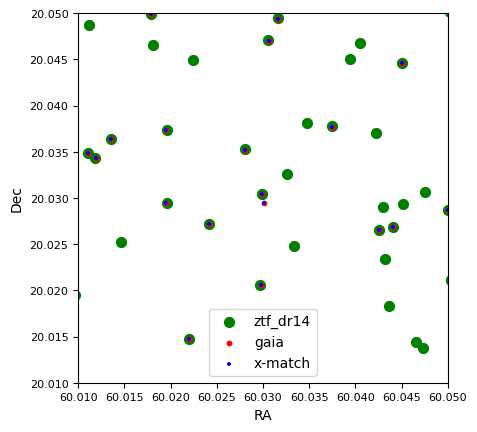

In [28]:
from matplotlib.ticker import StrMethodFormatter
plot_crossmatch(ztf_dr14, gaia_dr3, xmatched, window=[60.01, 60.05, 20.01, 20.05])
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
plt.tick_params(labelsize=8)